In [1]:
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import optuna
import json
import warnings

In [2]:
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
dataset_map = {
    '1': 'Energy',
    '2': 'Stock',
    '3': 'Traffic',
    '4': 'Weather'
}
dataset_choice = input("Select dataset (1. Energy 2. Stock 3. Traffic 4. Weather): ")
selected_dataset = dataset_map.get(dataset_choice)

Select dataset (1. Energy 2. Stock 3. Traffic 4. Weather):  2


In [4]:
base_models = ['LSTM', 'Transformer', 'LiquidML', 'XGBoost']
selected_models = []
for model in base_models:
    choice = input(f"Include {model} in ensemble? (y/n): ")
    if choice.lower() == 'y':
        selected_models.append(model)

Include LSTM in ensemble? (y/n):  y
Include Transformer in ensemble? (y/n):  y
Include LiquidML in ensemble? (y/n):  y
Include XGBoost in ensemble? (y/n):  y


In [5]:
dataset_files = {
    'Energy': '../datasets/AEP_hourly_processed.xlsx',
    'Stock': '../datasets/Tesla_Stock.xlsx',
    'Traffic': '../datasets/traffic.xlsx',
    'Weather': '../datasets/jena_climate.xlsx'
}
selected_file = dataset_files[selected_dataset]

In [6]:
X_train_meta, X_test_meta = [], []

for model in selected_models:
    X_train_meta.append(np.load(f"../{model}/predictions/{selected_dataset}_{model}_train.npy").reshape(-1))
    X_test_meta.append(np.load(f"../{model}/predictions/{selected_dataset}_{model}_test.npy").reshape(-1))

X_train_meta = np.stack(X_train_meta, axis=1)
X_test_meta = np.stack(X_test_meta, axis=1)

In [7]:
df = pd.read_excel(selected_file)

if selected_dataset == "Energy":
    df = df.iloc[:5000]
    target_column = "AEP_MW"
elif selected_dataset == "Stock":
    df = df.iloc[-2000:]
    target_column = "Close"
elif selected_dataset == "Traffic":
    df = df.iloc[-3000:]
    target_column = "Vehicles"
else:
    df = df.iloc[::144]
    target_column = "Tpot (K)"

full_target = df[target_column].values
split_idx = int(len(full_target) * 0.8)
y_train = full_target[:split_idx][60:]
y_test = full_target[split_idx:][60:]

In [8]:
X = X_train_meta
y = y_train

n_splits = 5
initial_train_size = int(len(X) * 0.5)
test_size = int((len(X) - initial_train_size) / n_splits)

oof_preds = np.zeros(len(y))
oof_indices = []

for i in range(n_splits):
    start = initial_train_size + i * test_size
    end = start + test_size

    if end > len(X): break

    X_train_fold = X[:start]
    y_train_fold = y[:start]
    X_valid_fold = X[start:end]
    y_valid_fold = y[start:end]

    meta_model = LGBMRegressor(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=3,
        reg_alpha=0.5,
        reg_lambda=1.0,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    meta_model.fit(X_train_fold, y_train_fold)

    preds = meta_model.predict(X_valid_fold)
    oof_preds[start:end] = preds
    oof_indices.extend(range(start, end))

valid_y = y[oof_indices]
valid_preds = oof_preds[oof_indices]
rmse_oof = mean_squared_error(valid_y, valid_preds, squared=False)
print(f"OOF Meta RMSE: {rmse_oof:.4f}")

  File "C:\Users\naman\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\naman\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\naman\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\naman\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1009
[LightGBM] [Info] Number of data points in the train set: 770, number of used features: 4
[LightGBM] [Info] Start training from score 19.199796
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [9]:
def objective(trial):
    params = {
        "n_estimators": 2000,
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 0.1),
        "num_leaves": trial.suggest_int("num_leaves", 32, 128),
        "max_depth": trial.suggest_int("max_depth", 6, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-4, 20.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-4, 20.0),
        "random_state": 42
    }

    model = LGBMRegressor(**params)
    model.fit(
        X_train_meta, y_train,
        eval_set=[(X_test_meta, y_test)],
        eval_metric="rmse",
        callbacks=[early_stopping(stopping_rounds=100), log_evaluation(period=0)]
    )

    preds = model.predict(X_test_meta)
    rmse = mean_squared_error(y_test, preds, squared=False)
    return rmse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=200)

[I 2025-05-31 01:33:48,437] A new study created in memory with name: no-name-0d81c95e-90a6-44df-9f33-afd2ad52ea88


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

[I 2025-05-31 01:33:48,942] Trial 0 finished with value: 13.160786491661241 and parameters: {'learning_rate': 0.008157617813021278, 'num_leaves': 50, 'max_depth': 6, 'min_child_samples': 78, 'subsample': 0.6857303864539055, 'colsample_bytree': 0.981116977370162, 'reg_alpha': 0.00025149851823051504, 'reg_lambda': 0.0008415071949666337}. Best is trial 0 with value: 13.160786491661241.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:33:49,988] Trial 1 finished with value: 16.238700068003016 and parameters: {'learning_rate': 0.0010491441737176047, 'num_leaves': 68, 'max_depth': 6, 'min_child_samples': 63, 'subsample': 0.649149370710586, 'colsample_bytree': 0.5469043455609903, 'reg_alpha': 15.947000556386342, 'reg_lambda': 0.13852835026838134}. Best is trial 0 with value: 13.160786491661241.
[I 2025-05-31 01:33:50,134] Trial 2 finished with value: 13.998016497074369 and parameters: {'learning_rate': 0.0361225984188882, 'num_leaves': 48, 'max_depth': 10, 'min_child_samples': 90, 'subsample': 0.5625158731817241, 'colsample_bytree': 0.9878397259544025, 'reg_alpha': 0.0003489875309921088, 'reg_lambda': 4.148428339208793}. Best is trial 0 with value: 13.160786491661241.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:33:50,584] Trial 3 finished with value: 11.508777684956614 and parameters: {'learning_rate': 0.004921116527681372, 'num_leaves': 125, 'max_depth': 9, 'min_child_samples': 28, 'subsample': 0.9704087392249161, 'colsample_bytree': 0.5313090112362845, 'reg_alpha': 6.703020284142952, 'reg_lambda': 0.020617977771913765}. Best is trial 3 with value: 11.508777684956614.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:33:51,651] Trial 4 finished with value: 11.39303694261882 and parameters: {'learning_rate': 0.0017710608873376876, 'num_leaves': 48, 'max_depth': 6, 'min_child_samples': 51, 'subsample': 0.5911411166257963, 'colsample_bytree': 0.6089508383549738, 'reg_alpha': 0.8089657145884847, 'reg_lambda': 0.0006473347313585477}. Best is trial 4 with value: 11.39303694261882.
[I 2025-05-31 01:33:51,770] Trial 5 finished with value: 11.30477432812984 and parameters: {'learning_rate': 0.09311969694136643, 'num_leaves': 90, 'max_depth': 10, 'min_child_samples': 27, 'subsample': 0.7442124701255878, 'colsample_bytree': 0.5330749685701855, 'reg_alpha': 0.00027236107652545, 'reg_lambda': 0.012826043669571187}. Best is trial 5 with value: 11.30477432812984.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:33:51,984] Trial 6 finished with value: 14.55741023081083 and parameters: {'learning_rate': 0.015541296497539304, 'num_leaves': 49, 'max_depth': 10, 'min_child_samples': 92, 'subsample': 0.5437963932549729, 'colsample_bytree': 0.9877373431846025, 'reg_alpha': 0.20085465613054423, 'reg_lambda': 0.00047248407869196946}. Best is trial 5 with value: 11.30477432812984.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:33:52,586] Trial 7 finished with value: 12.191950109196972 and parameters: {'learning_rate': 0.003090388758711726, 'num_leaves': 67, 'max_depth': 7, 'min_child_samples': 32, 'subsample': 0.9640652256390463, 'colsample_bytree': 0.8458131861127909, 'reg_alpha': 0.003693461862190744, 'reg_lambda': 7.6812476447944205}. Best is trial 5 with value: 11.30477432812984.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:33:52,763] Trial 8 finished with value: 12.242811937718708 and parameters: {'learning_rate': 0.01484093427995092, 'num_leaves': 78, 'max_depth': 6, 'min_child_samples': 12, 'subsample': 0.9502204558666144, 'colsample_bytree': 0.8702012556916476, 'reg_alpha': 5.101365891964383, 'reg_lambda': 0.2985646584176618}. Best is trial 5 with value: 11.30477432812984.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:33:53,032] Trial 9 finished with value: 12.47128163182772 and parameters: {'learning_rate': 0.02928994577066792, 'num_leaves': 33, 'max_depth': 10, 'min_child_samples': 19, 'subsample': 0.9309437131098772, 'colsample_bytree': 0.6532015876226456, 'reg_alpha': 0.00040921576246361687, 'reg_lambda': 0.0059068566660525216}. Best is trial 5 with value: 11.30477432812984.
[I 2025-05-31 01:33:53,170] Trial 10 finished with value: 11.948392053482943 and parameters: {'learning_rate': 0.09508594609851267, 'num_leaves': 110, 'max_depth': 8, 'min_child_samples': 45, 'subsample': 0.825804476853905, 'colsample_bytree': 0.720239351963153, 'reg_alpha': 0.011904140954165686, 'reg_lambda': 0.00010293960533680442}. Best is trial 5 with value: 11.30477432812984.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[113]	valid_0's rmse: 12.4713	valid_0's l2: 155.533
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start tr

[I 2025-05-31 01:33:54,401] Trial 11 finished with value: 17.053532492170607 and parameters: {'learning_rate': 0.0010139381364505735, 'num_leaves': 94, 'max_depth': 8, 'min_child_samples': 53, 'subsample': 0.79092600980031, 'colsample_bytree': 0.6237121708092459, 'reg_alpha': 0.3715021184631405, 'reg_lambda': 0.003938538290043343}. Best is trial 5 with value: 11.30477432812984.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:33:55,377] Trial 12 finished with value: 11.20605571462333 and parameters: {'learning_rate': 0.0023940390067417367, 'num_leaves': 94, 'max_depth': 7, 'min_child_samples': 42, 'subsample': 0.6776311181090864, 'colsample_bytree': 0.6139729037569819, 'reg_alpha': 0.3619656811374884, 'reg_lambda': 0.0022915290320348154}. Best is trial 12 with value: 11.20605571462333.
[I 2025-05-31 01:33:55,531] Trial 13 finished with value: 10.925158099652036 and parameters: {'learning_rate': 0.08668392516454197, 'num_leaves': 97, 'max_depth': 7, 'min_child_samples': 38, 'subsample': 0.7281883428493906, 'colsample_bytree': 0.5205395441630799, 'reg_alpha': 0.02827971422788209, 'reg_lambda': 0.027479605665902598}. Best is trial 13 with value: 10.925158099652036.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:33:56,284] Trial 14 finished with value: 12.735348569070728 and parameters: {'learning_rate': 0.003305827571637254, 'num_leaves': 105, 'max_depth': 7, 'min_child_samples': 40, 'subsample': 0.6964190198072177, 'colsample_bytree': 0.6923009757489127, 'reg_alpha': 0.04693650903516759, 'reg_lambda': 0.1316257892199735}. Best is trial 13 with value: 10.925158099652036.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:33:56,649] Trial 15 finished with value: 12.771530180528915 and parameters: {'learning_rate': 0.0068039002759269895, 'num_leaves': 115, 'max_depth': 7, 'min_child_samples': 62, 'subsample': 0.8582184216417191, 'colsample_bytree': 0.7739211545712379, 'reg_alpha': 0.04534519584359695, 'reg_lambda': 0.8567217553654016}. Best is trial 13 with value: 10.925158099652036.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:33:56,786] Trial 16 finished with value: 10.61886151449429 and parameters: {'learning_rate': 0.054726989107128345, 'num_leaves': 97, 'max_depth': 7, 'min_child_samples': 73, 'subsample': 0.6195153975085915, 'colsample_bytree': 0.6063953241957651, 'reg_alpha': 0.003452037288692374, 'reg_lambda': 0.002061766024394266}. Best is trial 16 with value: 10.61886151449429.
[I 2025-05-31 01:33:56,969] Trial 17 finished with value: 10.70911047531583 and parameters: {'learning_rate': 0.0508615730161937, 'num_leaves': 84, 'max_depth': 8, 'min_child_samples': 75, 'subsample': 0.6136186375153299, 'colsample_bytree': 0.5097864832981349, 'reg_alpha': 0.0029359979433685813, 'reg_lambda': 0.04767365603274479}. Best is trial 16 with value: 10.61886151449429.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:33:57,094] Trial 18 finished with value: 10.660413656341163 and parameters: {'learning_rate': 0.042730235113267054, 'num_leaves': 81, 'max_depth': 9, 'min_child_samples': 73, 'subsample': 0.5030733765063289, 'colsample_bytree': 0.581284382532739, 'reg_alpha': 0.0022362439776915564, 'reg_lambda': 0.06649251681670615}. Best is trial 16 with value: 10.61886151449429.
[I 2025-05-31 01:33:57,236] Trial 19 finished with value: 12.551209671572588 and parameters: {'learning_rate': 0.020377882451002062, 'num_leaves': 72, 'max_depth': 9, 'min_child_samples': 80, 'subsample': 0.5016183491846683, 'colsample_bytree': 0.7718294514092087, 'reg_alpha': 0.001420338844545456, 'reg_lambda': 2.268670188322563}. Best is trial 16 with value: 10.61886151449429.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:33:57,409] Trial 20 finished with value: 10.638680191908609 and parameters: {'learning_rate': 0.05623143468586329, 'num_leaves': 126, 'max_depth': 9, 'min_child_samples': 71, 'subsample': 0.5309597660288752, 'colsample_bytree': 0.587381480465714, 'reg_alpha': 0.00135259137996855, 'reg_lambda': 0.00015537867968247948}. Best is trial 16 with value: 10.61886151449429.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:33:57,550] Trial 21 finished with value: 11.028849477958275 and parameters: {'learning_rate': 0.05322037458694564, 'num_leaves': 120, 'max_depth': 9, 'min_child_samples': 66, 'subsample': 0.5176741818397186, 'colsample_bytree': 0.5746291833559363, 'reg_alpha': 0.0012882213173300515, 'reg_lambda': 0.00010197737460532182}. Best is trial 16 with value: 10.61886151449429.
[I 2025-05-31 01:33:57,678] Trial 22 finished with value: 11.691392054219264 and parameters: {'learning_rate': 0.05248658287654392, 'num_leaves': 104, 'max_depth': 9, 'min_child_samples': 71, 'subsample': 0.6057774901987288, 'colsample_bytree': 0.6715225168781875, 'reg_alpha': 0.009196866073785512, 'reg_lambda': 0.00025612907719594144}. Best is trial 16 with value: 10.61886151449429.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:33:57,810] Trial 23 finished with value: 12.451321912551084 and parameters: {'learning_rate': 0.030091254421651028, 'num_leaves': 83, 'max_depth': 9, 'min_child_samples': 100, 'subsample': 0.5576435494070258, 'colsample_bytree': 0.583105546683731, 'reg_alpha': 0.0001040301849449439, 'reg_lambda': 0.0017331646041687627}. Best is trial 16 with value: 10.61886151449429.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:33:57,976] Trial 24 finished with value: 11.93534005448458 and parameters: {'learning_rate': 0.05795390457295021, 'num_leaves': 128, 'max_depth': 8, 'min_child_samples': 86, 'subsample': 0.5024636114926015, 'colsample_bytree': 0.5732449779998527, 'reg_alpha': 0.0010677635551940628, 'reg_lambda': 0.008183251549059016}. Best is trial 16 with value: 10.61886151449429.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:33:58,164] Trial 25 finished with value: 12.719657837222154 and parameters: {'learning_rate': 0.02213589933251378, 'num_leaves': 102, 'max_depth': 9, 'min_child_samples': 58, 'subsample': 0.6155934697938162, 'colsample_bytree': 0.6433953077713832, 'reg_alpha': 0.006105856074928572, 'reg_lambda': 0.061462086454425635}. Best is trial 16 with value: 10.61886151449429.
[I 2025-05-31 01:33:58,298] Trial 26 finished with value: 12.034407095542361 and parameters: {'learning_rate': 0.04199904654937429, 'num_leaves': 115, 'max_depth': 8, 'min_child_samples': 70, 'subsample': 0.5708865837452675, 'colsample_bytree': 0.7084778656006842, 'reg_alpha': 0.0007600394168836755, 'reg_lambda': 0.0002530307362234488}. Best is trial 16 with value: 10.61886151449429.
[I 2025-05-31 01:33:58,426] Trial 27 finished with value: 11.14537777315929 and parameters: {'learning_rate': 0.07181118405886601, 'num_leaves': 61, 'max_depth': 8, 'min_child_samples': 82, 'subsample': 0.5393764231952021, 'cols

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:33:58,605] Trial 28 finished with value: 12.048115153726561 and parameters: {'learning_rate': 0.023236491136280173, 'num_leaves': 87, 'max_depth': 9, 'min_child_samples': 72, 'subsample': 0.6482654637299098, 'colsample_bytree': 0.7400651368826305, 'reg_alpha': 0.003058150914910697, 'reg_lambda': 0.5025875550979181}. Best is trial 16 with value: 10.61886151449429.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:33:58,947] Trial 29 finished with value: 13.421358285325342 and parameters: {'learning_rate': 0.01375146390928937, 'num_leaves': 59, 'max_depth': 10, 'min_child_samples': 79, 'subsample': 0.6432882095427298, 'colsample_bytree': 0.9218398472061455, 'reg_alpha': 0.00015868768860854933, 'reg_lambda': 0.0005646943220458757}. Best is trial 16 with value: 10.61886151449429.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:33:59,174] Trial 30 finished with value: 14.210432334286876 and parameters: {'learning_rate': 0.008605743117239072, 'num_leaves': 76, 'max_depth': 9, 'min_child_samples': 98, 'subsample': 0.5320657641099671, 'colsample_bytree': 0.671086786068877, 'reg_alpha': 0.0948010230705993, 'reg_lambda': 0.001404875943109931}. Best is trial 16 with value: 10.61886151449429.
[I 2025-05-31 01:33:59,337] Trial 31 finished with value: 10.650229087548633 and parameters: {'learning_rate': 0.04507034434474341, 'num_leaves': 83, 'max_depth': 8, 'min_child_samples': 75, 'subsample': 0.602166968789717, 'colsample_bytree': 0.5034642385419054, 'reg_alpha': 0.00299527291443808, 'reg_lambda': 0.05508830690427856}. Best is trial 16 with value: 10.61886151449429.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:33:59,464] Trial 32 finished with value: 11.17530367079024 and parameters: {'learning_rate': 0.06963358172143021, 'num_leaves': 75, 'max_depth': 7, 'min_child_samples': 64, 'subsample': 0.5688916118883343, 'colsample_bytree': 0.5529093706707865, 'reg_alpha': 0.002286277866309297, 'reg_lambda': 0.09560224641266094}. Best is trial 16 with value: 10.61886151449429.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:33:59,650] Trial 33 finished with value: 11.747129524687614 and parameters: {'learning_rate': 0.03814144650773203, 'num_leaves': 99, 'max_depth': 8, 'min_child_samples': 85, 'subsample': 0.6816976137678306, 'colsample_bytree': 0.5062663895755063, 'reg_alpha': 0.005093679805165353, 'reg_lambda': 0.25802302945922373}. Best is trial 16 with value: 10.61886151449429.
[I 2025-05-31 01:33:59,800] Trial 34 finished with value: 11.14833531353494 and parameters: {'learning_rate': 0.030106421231520807, 'num_leaves': 67, 'max_depth': 6, 'min_child_samples': 59, 'subsample': 0.5903337405248373, 'colsample_bytree': 0.6008072514351361, 'reg_alpha': 0.0005712957229998026, 'reg_lambda': 0.019444331934505017}. Best is trial 16 with value: 10.61886151449429.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:33:59,946] Trial 35 finished with value: 11.83041670888068 and parameters: {'learning_rate': 0.04139860445225404, 'num_leaves': 90, 'max_depth': 8, 'min_child_samples': 90, 'subsample': 0.632752566248234, 'colsample_bytree': 0.5549450771452827, 'reg_alpha': 0.0016681650688601469, 'reg_lambda': 0.009631474799947474}. Best is trial 16 with value: 10.61886151449429.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:00,083] Trial 36 finished with value: 10.694188853288031 and parameters: {'learning_rate': 0.06433484628670542, 'num_leaves': 57, 'max_depth': 9, 'min_child_samples': 75, 'subsample': 0.5804771126422472, 'colsample_bytree': 0.5005910368442774, 'reg_alpha': 0.012906359906552494, 'reg_lambda': 0.02875607906025924}. Best is trial 16 with value: 10.61886151449429.
[I 2025-05-31 01:34:00,230] Trial 37 finished with value: 10.671756885060375 and parameters: {'learning_rate': 0.04259134734373343, 'num_leaves': 81, 'max_depth': 10, 'min_child_samples': 67, 'subsample': 0.5245949075787333, 'colsample_bytree': 0.5465356805869039, 'reg_alpha': 0.00022078145961651246, 'reg_lambda': 0.0002444953886496801}. Best is trial 16 with value: 10.61886151449429.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:00,372] Trial 38 finished with value: 12.343780825109857 and parameters: {'learning_rate': 0.027246468934483233, 'num_leaves': 120, 'max_depth': 6, 'min_child_samples': 49, 'subsample': 0.712357673370438, 'colsample_bytree': 0.6337553599132306, 'reg_alpha': 0.0005157881728942542, 'reg_lambda': 18.786668806110033}. Best is trial 16 with value: 10.61886151449429.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:00,666] Trial 39 finished with value: 10.734805154462165 and parameters: {'learning_rate': 0.01830636397562031, 'num_leaves': 88, 'max_depth': 9, 'min_child_samples': 76, 'subsample': 0.7708458138855914, 'colsample_bytree': 0.5941854652321396, 'reg_alpha': 0.007171443287834991, 'reg_lambda': 0.0010683069221839312}. Best is trial 16 with value: 10.61886151449429.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:00,947] Trial 40 finished with value: 10.975634513936825 and parameters: {'learning_rate': 0.07628922914903691, 'num_leaves': 40, 'max_depth': 7, 'min_child_samples': 57, 'subsample': 0.6609915305199019, 'colsample_bytree': 0.525868498036178, 'reg_alpha': 0.0008789603825493055, 'reg_lambda': 0.08127382723323527}. Best is trial 16 with value: 10.61886151449429.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:01,172] Trial 41 finished with value: 10.711788889710299 and parameters: {'learning_rate': 0.04092736606667117, 'num_leaves': 83, 'max_depth': 10, 'min_child_samples': 67, 'subsample': 0.5307975717064288, 'colsample_bytree': 0.5480001522665912, 'reg_alpha': 0.00019614593192659622, 'reg_lambda': 0.00025714186986585053}. Best is trial 16 with value: 10.61886151449429.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:01,437] Trial 42 finished with value: 10.681093273813877 and parameters: {'learning_rate': 0.04612034431409014, 'num_leaves': 80, 'max_depth': 10, 'min_child_samples': 70, 'subsample': 0.5530995773691691, 'colsample_bytree': 0.5432504380088112, 'reg_alpha': 0.00030146775211224887, 'reg_lambda': 0.00018313423345060384}. Best is trial 16 with value: 10.61886151449429.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:01,805] Trial 43 finished with value: 11.1835480100747 and parameters: {'learning_rate': 0.03400514812809665, 'num_leaves': 72, 'max_depth': 10, 'min_child_samples': 62, 'subsample': 0.5013720046255937, 'colsample_bytree': 0.5613678596575834, 'reg_alpha': 0.0021644504956992426, 'reg_lambda': 0.0004667486108927519}. Best is trial 16 with value: 10.61886151449429.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:02,332] Trial 44 finished with value: 11.255412203794116 and parameters: {'learning_rate': 0.01148076142570984, 'num_leaves': 93, 'max_depth': 10, 'min_child_samples': 83, 'subsample': 0.5239536212212165, 'colsample_bytree': 0.6053293306140831, 'reg_alpha': 0.00011125244065444342, 'reg_lambda': 0.0007480589322317143}. Best is trial 16 with value: 10.61886151449429.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:02,547] Trial 45 finished with value: 13.117432774684158 and parameters: {'learning_rate': 0.09130022892553095, 'num_leaves': 66, 'max_depth': 10, 'min_child_samples': 89, 'subsample': 0.5948437580277999, 'colsample_bytree': 0.8204548095352495, 'reg_alpha': 0.0002993496050800217, 'reg_lambda': 0.004425294946909016}. Best is trial 16 with value: 10.61886151449429.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:02,739] Trial 46 finished with value: 10.648277674028657 and parameters: {'learning_rate': 0.06190272201926522, 'num_leaves': 110, 'max_depth': 8, 'min_child_samples': 68, 'subsample': 0.5651891348051631, 'colsample_bytree': 0.5387558909236307, 'reg_alpha': 0.004215433686194522, 'reg_lambda': 0.21590165955781157}. Best is trial 16 with value: 10.61886151449429.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:02,915] Trial 47 finished with value: 10.664727554353389 and parameters: {'learning_rate': 0.0583677468529245, 'num_leaves': 110, 'max_depth': 8, 'min_child_samples': 77, 'subsample': 0.6275696767788114, 'colsample_bytree': 0.620517698347764, 'reg_alpha': 0.004379956078287089, 'reg_lambda': 0.2465351886001513}. Best is trial 16 with value: 10.61886151449429.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:03,231] Trial 48 finished with value: 10.716941818276775 and parameters: {'learning_rate': 0.07636913234928361, 'num_leaves': 109, 'max_depth': 8, 'min_child_samples': 73, 'subsample': 0.555127219938499, 'colsample_bytree': 0.5250979036317487, 'reg_alpha': 0.017269881598104386, 'reg_lambda': 0.8483298030382826}. Best is trial 16 with value: 10.61886151449429.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:03,587] Trial 49 finished with value: 12.539213114003282 and parameters: {'learning_rate': 0.033596981257357376, 'num_leaves': 123, 'max_depth': 7, 'min_child_samples': 51, 'subsample': 0.5926575430128449, 'colsample_bytree': 0.6604991735719515, 'reg_alpha': 2.2993556581335377, 'reg_lambda': 0.15603848325276465}. Best is trial 16 with value: 10.61886151449429.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:03,776] Trial 50 finished with value: 10.914203387846475 and parameters: {'learning_rate': 0.09621157914834981, 'num_leaves': 97, 'max_depth': 7, 'min_child_samples': 80, 'subsample': 0.8960373317512031, 'colsample_bytree': 0.5923467951638482, 'reg_alpha': 0.08505763779513514, 'reg_lambda': 1.7036661444967176}. Best is trial 16 with value: 10.61886151449429.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:04,090] Trial 51 finished with value: 10.665941667144592 and parameters: {'learning_rate': 0.059285200566138035, 'num_leaves': 117, 'max_depth': 8, 'min_child_samples': 78, 'subsample': 0.6642707427723421, 'colsample_bytree': 0.62288530967606, 'reg_alpha': 0.0050895043318089335, 'reg_lambda': 0.1943446691764629}. Best is trial 16 with value: 10.61886151449429.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:04,366] Trial 52 finished with value: 10.709012880105915 and parameters: {'learning_rate': 0.062391516201128566, 'num_leaves': 109, 'max_depth': 8, 'min_child_samples': 68, 'subsample': 0.6162396419345985, 'colsample_bytree': 0.5298538602586167, 'reg_alpha': 0.004067272023838252, 'reg_lambda': 0.4271526817762513}. Best is trial 16 with value: 10.61886151449429.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:06,644] Trial 53 finished with value: 12.594734153198678 and parameters: {'learning_rate': 0.0014213362497353136, 'num_leaves': 112, 'max_depth': 8, 'min_child_samples': 93, 'subsample': 0.6359065122232561, 'colsample_bytree': 0.6166185932418649, 'reg_alpha': 0.0020761899108455257, 'reg_lambda': 0.038482210497771105}. Best is trial 16 with value: 10.61886151449429.
[I 2025-05-31 01:34:06,924] Trial 54 finished with value: 10.666920602333274 and parameters: {'learning_rate': 0.05162501433828698, 'num_leaves': 127, 'max_depth': 9, 'min_child_samples': 74, 'subsample': 0.5719560871346099, 'colsample_bytree': 0.567761865545369, 'reg_alpha': 0.010025875983861345, 'reg_lambda': 0.013380484628673427}. Best is trial 16 with value: 10.61886151449429.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:07,116] Trial 55 finished with value: 12.390281040279481 and parameters: {'learning_rate': 0.08052879110075781, 'num_leaves': 106, 'max_depth': 8, 'min_child_samples': 61, 'subsample': 0.5440217354473262, 'colsample_bytree': 0.6929809578126738, 'reg_alpha': 18.1845125130752, 'reg_lambda': 0.10394691051453507}. Best is trial 16 with value: 10.61886151449429.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:07,458] Trial 56 finished with value: 12.906534615516822 and parameters: {'learning_rate': 0.02639690860554109, 'num_leaves': 102, 'max_depth': 7, 'min_child_samples': 77, 'subsample': 0.7015563858732299, 'colsample_bytree': 0.9478133744575135, 'reg_alpha': 0.003469935044245123, 'reg_lambda': 0.05260525296359111}. Best is trial 16 with value: 10.61886151449429.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[128]	valid_0's rmse: 12.9065	valid_0's l2: 166.579
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-05-31 01:34:07,701] Trial 57 finished with value: 12.796385272977401 and parameters: {'learning_rate': 0.049009510820339795, 'num_leaves': 122, 'max_depth': 8, 'min_child_samples': 87, 'subsample': 0.6103665177737325, 'colsample_bytree': 0.6445668082533185, 'reg_alpha': 0.001132155546048831, 'reg_lambda': 0.5197655069001412}. Best is trial 16 with value: 10.61886151449429.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:07,972] Trial 58 finished with value: 10.99585436821541 and parameters: {'learning_rate': 0.05972079421869939, 'num_leaves': 114, 'max_depth': 9, 'min_child_samples': 55, 'subsample': 0.9898997494248981, 'colsample_bytree': 0.5808245943209092, 'reg_alpha': 0.027866258151535865, 'reg_lambda': 0.020660052681122247}. Best is trial 16 with value: 10.61886151449429.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:08,176] Trial 59 finished with value: 11.143058412357416 and parameters: {'learning_rate': 0.03384775290770355, 'num_leaves': 100, 'max_depth': 9, 'min_child_samples': 83, 'subsample': 0.6245320577008164, 'colsample_bytree': 0.5126201334780764, 'reg_alpha': 0.007115361305660659, 'reg_lambda': 0.27058972662094727}. Best is trial 16 with value: 10.61886151449429.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:08,509] Trial 60 finished with value: 12.599317654573934 and parameters: {'learning_rate': 0.018415093295321757, 'num_leaves': 92, 'max_depth': 8, 'min_child_samples': 64, 'subsample': 0.5121087091059827, 'colsample_bytree': 0.6315544586916801, 'reg_alpha': 0.0007730828083079536, 'reg_lambda': 0.06431803944768638}. Best is trial 16 with value: 10.61886151449429.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:09,098] Trial 61 finished with value: 11.29716329436883 and parameters: {'learning_rate': 0.005963926230121438, 'num_leaves': 115, 'max_depth': 8, 'min_child_samples': 79, 'subsample': 0.6708194967977205, 'colsample_bytree': 0.6115509719872646, 'reg_alpha': 0.005683639393223843, 'reg_lambda': 0.16156765669060302}. Best is trial 16 with value: 10.61886151449429.
[I 2025-05-31 01:34:09,323] Trial 62 finished with value: 10.706921063449782 and parameters: {'learning_rate': 0.057919209592359674, 'num_leaves': 118, 'max_depth': 8, 'min_child_samples': 70, 'subsample': 0.7312703721414703, 'colsample_bytree': 0.623245461215882, 'reg_alpha': 0.003917592994709512, 'reg_lambda': 0.15493093509120817}. Best is trial 16 with value: 10.61886151449429.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:09,503] Trial 63 finished with value: 10.59105984632066 and parameters: {'learning_rate': 0.06744731304644752, 'num_leaves': 108, 'max_depth': 8, 'min_child_samples': 76, 'subsample': 0.6624313045261064, 'colsample_bytree': 0.5851468586430302, 'reg_alpha': 0.0019069569829808055, 'reg_lambda': 0.21785450356574287}. Best is trial 63 with value: 10.59105984632066.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:09,699] Trial 64 finished with value: 10.645701511610628 and parameters: {'learning_rate': 0.06958536131314629, 'num_leaves': 106, 'max_depth': 9, 'min_child_samples': 73, 'subsample': 0.5984956509133861, 'colsample_bytree': 0.5362025202005118, 'reg_alpha': 0.001474070455838199, 'reg_lambda': 0.28376741118735105}. Best is trial 63 with value: 10.59105984632066.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:09,887] Trial 65 finished with value: 10.745762438203847 and parameters: {'learning_rate': 0.07028009431809543, 'num_leaves': 106, 'max_depth': 9, 'min_child_samples': 73, 'subsample': 0.5837345533728769, 'colsample_bytree': 0.5330415030568117, 'reg_alpha': 0.0015339690686158466, 'reg_lambda': 0.94435668260559}. Best is trial 63 with value: 10.59105984632066.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:10,065] Trial 66 finished with value: 11.085552143582229 and parameters: {'learning_rate': 0.08215492545613771, 'num_leaves': 87, 'max_depth': 9, 'min_child_samples': 66, 'subsample': 0.6011426753674867, 'colsample_bytree': 0.5656553511044099, 'reg_alpha': 0.0004665650640381948, 'reg_lambda': 0.3858323854412984}. Best is trial 63 with value: 10.59105984632066.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:10,306] Trial 67 finished with value: 11.102401639085166 and parameters: {'learning_rate': 0.04638626788473664, 'num_leaves': 99, 'max_depth': 9, 'min_child_samples': 82, 'subsample': 0.5607483687600473, 'colsample_bytree': 0.5888241175258134, 'reg_alpha': 0.002058103096521397, 'reg_lambda': 0.035724055189341866}. Best is trial 63 with value: 10.59105984632066.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:10,484] Trial 68 finished with value: 10.590182783169388 and parameters: {'learning_rate': 0.0679387849459224, 'num_leaves': 96, 'max_depth': 9, 'min_child_samples': 69, 'subsample': 0.5429958014176789, 'colsample_bytree': 0.5127476134698412, 'reg_alpha': 0.0027668946381566354, 'reg_lambda': 0.6723144881357174}. Best is trial 68 with value: 10.590182783169388.
[I 2025-05-31 01:34:10,646] Trial 69 finished with value: 10.684366937493317 and parameters: {'learning_rate': 0.08904213769460528, 'num_leaves': 104, 'max_depth': 9, 'min_child_samples': 68, 'subsample': 0.5464330501454053, 'colsample_bytree': 0.5377808337667138, 'reg_alpha': 0.0006294843295017752, 'reg_lambda': 3.308175030198023}. Best is trial 68 with value: 10.590182783169388.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[48]	valid_0's rmse: 10.5902	valid_0's l2: 112.152
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-05-31 01:34:10,811] Trial 70 finished with value: 11.006636957953054 and parameters: {'learning_rate': 0.0668075056394983, 'num_leaves': 96, 'max_depth': 7, 'min_child_samples': 12, 'subsample': 0.6501530504927565, 'colsample_bytree': 0.5148760989796598, 'reg_alpha': 0.0011609352425513805, 'reg_lambda': 1.2523260923353519}. Best is trial 68 with value: 10.590182783169388.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:10,951] Trial 71 finished with value: 10.586160656655148 and parameters: {'learning_rate': 0.09994537580957674, 'num_leaves': 90, 'max_depth': 9, 'min_child_samples': 71, 'subsample': 0.5727634333776825, 'colsample_bytree': 0.5045206930568048, 'reg_alpha': 0.0027583441964588043, 'reg_lambda': 0.6782139738449459}. Best is trial 71 with value: 10.586160656655148.
[I 2025-05-31 01:34:11,074] Trial 72 finished with value: 10.677377235963506 and parameters: {'learning_rate': 0.09898178341808588, 'num_leaves': 90, 'max_depth': 9, 'min_child_samples': 71, 'subsample': 0.5770423904654536, 'colsample_bytree': 0.5093835206197578, 'reg_alpha': 0.0028204644972483796, 'reg_lambda': 0.6592086713870325}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[31]	valid_0's rmse: 10.5862	valid_0's l2: 112.067
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-05-31 01:34:11,240] Trial 73 finished with value: 11.091476070065315 and parameters: {'learning_rate': 0.07930967552447898, 'num_leaves': 95, 'max_depth': 9, 'min_child_samples': 64, 'subsample': 0.6044091115273191, 'colsample_bytree': 0.503171863772039, 'reg_alpha': 0.0015152324096803723, 'reg_lambda': 0.36526384504322856}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:11,721] Trial 74 finished with value: 10.85237060328863 and parameters: {'learning_rate': 0.004230115307020629, 'num_leaves': 85, 'max_depth': 9, 'min_child_samples': 76, 'subsample': 0.5650693047763958, 'colsample_bytree': 0.5548312240428535, 'reg_alpha': 0.007683280370252154, 'reg_lambda': 0.6428281883684459}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:11,912] Trial 75 finished with value: 11.238389702458456 and parameters: {'learning_rate': 0.06846015646583267, 'num_leaves': 102, 'max_depth': 8, 'min_child_samples': 23, 'subsample': 0.5382087518543033, 'colsample_bytree': 0.5226624105140304, 'reg_alpha': 0.0131990960399601, 'reg_lambda': 5.405161196987598}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:12,073] Trial 76 finished with value: 10.812530963203553 and parameters: {'learning_rate': 0.053819738932425164, 'num_leaves': 108, 'max_depth': 9, 'min_child_samples': 70, 'subsample': 0.5747732354563745, 'colsample_bytree': 0.543908852878683, 'reg_alpha': 0.0009168512386440984, 'reg_lambda': 1.5197837323515453}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:12,251] Trial 77 finished with value: 10.795996271994344 and parameters: {'learning_rate': 0.09946160606120909, 'num_leaves': 91, 'max_depth': 9, 'min_child_samples': 74, 'subsample': 0.5888657035020386, 'colsample_bytree': 0.5004594525416765, 'reg_alpha': 0.0026060677881556047, 'reg_lambda': 0.11798603220787152}. Best is trial 71 with value: 10.586160656655148.
[I 2025-05-31 01:34:12,395] Trial 78 finished with value: 11.061018496872553 and parameters: {'learning_rate': 0.03658510917290317, 'num_leaves': 113, 'max_depth': 6, 'min_child_samples': 81, 'subsample': 0.5158716817707694, 'colsample_bytree': 0.5648130235761423, 'reg_alpha': 0.00041670752532045423, 'reg_lambda': 2.220124352270187}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[33]	valid_0's rmse: 10.796	valid_0's l2: 116.554
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve fo

[I 2025-05-31 01:34:12,627] Trial 79 finished with value: 11.059635276241927 and parameters: {'learning_rate': 0.04740727636880722, 'num_leaves': 99, 'max_depth': 8, 'min_child_samples': 33, 'subsample': 0.8294554577770006, 'colsample_bytree': 0.537486383634955, 'reg_alpha': 0.0016685728607782621, 'reg_lambda': 0.2372928364309107}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:12,779] Trial 80 finished with value: 11.042054432726632 and parameters: {'learning_rate': 0.08734364498358645, 'num_leaves': 95, 'max_depth': 9, 'min_child_samples': 60, 'subsample': 0.6481971239599157, 'colsample_bytree': 0.5195006916593848, 'reg_alpha': 0.0031356570898601072, 'reg_lambda': 0.9584953780930242}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:12,964] Trial 81 finished with value: 10.62450149246935 and parameters: {'learning_rate': 0.07230390446525883, 'num_leaves': 77, 'max_depth': 9, 'min_child_samples': 72, 'subsample': 0.5326110933428433, 'colsample_bytree': 0.5799914367964806, 'reg_alpha': 0.0019738871607298696, 'reg_lambda': 0.07540359105742299}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:13,113] Trial 82 finished with value: 10.672883787447192 and parameters: {'learning_rate': 0.07265414513006302, 'num_leaves': 78, 'max_depth': 9, 'min_child_samples': 68, 'subsample': 0.5564477834267102, 'colsample_bytree': 0.5763547565508105, 'reg_alpha': 0.0017648964868603176, 'reg_lambda': 0.08276770496434116}. Best is trial 71 with value: 10.586160656655148.
[I 2025-05-31 01:34:13,269] Trial 83 finished with value: 11.068917793085044 and parameters: {'learning_rate': 0.06576583514590506, 'num_leaves': 72, 'max_depth': 9, 'min_child_samples': 65, 'subsample': 0.5323220282276807, 'colsample_bytree': 0.5553349836309923, 'reg_alpha': 0.0007250195544105134, 'reg_lambda': 0.11754882438318265}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[45]	valid_0's rmse: 10.6729	valid_0's l2: 113.91
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2025-05-31 01:34:13,441] Trial 84 finished with value: 10.686483328203416 and parameters: {'learning_rate': 0.05356870653866198, 'num_leaves': 86, 'max_depth': 9, 'min_child_samples': 72, 'subsample': 0.5841286384439481, 'colsample_bytree': 0.6045284630432759, 'reg_alpha': 0.0009883605949230405, 'reg_lambda': 0.32600819079691934}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:13,583] Trial 85 finished with value: 10.684492438811345 and parameters: {'learning_rate': 0.08269684326518395, 'num_leaves': 82, 'max_depth': 8, 'min_child_samples': 75, 'subsample': 0.6187589091045187, 'colsample_bytree': 0.5343112422513601, 'reg_alpha': 0.002622139645307622, 'reg_lambda': 0.6299266693347717}. Best is trial 71 with value: 10.586160656655148.
[I 2025-05-31 01:34:13,723] Trial 86 finished with value: 11.764216937099729 and parameters: {'learning_rate': 0.03972670628108841, 'num_leaves': 89, 'max_depth': 9, 'min_child_samples': 85, 'subsample': 0.5455281557445001, 'colsample_bytree': 0.592072443873804, 'reg_alpha': 0.004615316158109612, 'reg_lambda': 0.20894081242372395}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:13,878] Trial 87 finished with value: 10.644645195638782 and parameters: {'learning_rate': 0.076483916139309, 'num_leaves': 76, 'max_depth': 8, 'min_child_samples': 78, 'subsample': 0.6004799120356735, 'colsample_bytree': 0.5185815440089152, 'reg_alpha': 0.0012073005114863107, 'reg_lambda': 0.00215996238060807}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:14,019] Trial 88 finished with value: 10.644296556312472 and parameters: {'learning_rate': 0.07478149796061019, 'num_leaves': 76, 'max_depth': 9, 'min_child_samples': 78, 'subsample': 0.5148379807542426, 'colsample_bytree': 0.5508861384957472, 'reg_alpha': 0.0013733295918091656, 'reg_lambda': 0.000399049432265431}. Best is trial 71 with value: 10.586160656655148.
[I 2025-05-31 01:34:14,210] Trial 89 finished with value: 11.140875474860675 and parameters: {'learning_rate': 0.07638140625020837, 'num_leaves': 74, 'max_depth': 9, 'min_child_samples': 79, 'subsample': 0.5145173313871441, 'colsample_bytree': 0.5734914345355349, 'reg_alpha': 0.0012060302188710431, 'reg_lambda': 0.0001295722245874409}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[42]	valid_0's rmse: 10.6443	valid_0's l2: 113.301
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in 

[I 2025-05-31 01:34:14,342] Trial 90 finished with value: 13.113292165695507 and parameters: {'learning_rate': 0.08911178783185494, 'num_leaves': 63, 'max_depth': 9, 'min_child_samples': 88, 'subsample': 0.5177543522856497, 'colsample_bytree': 0.7823907103551113, 'reg_alpha': 0.0006003757044166871, 'reg_lambda': 0.00036728818799232994}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:14,513] Trial 91 finished with value: 10.647581640028983 and parameters: {'learning_rate': 0.06163650998800592, 'num_leaves': 79, 'max_depth': 9, 'min_child_samples': 70, 'subsample': 0.5336056486830005, 'colsample_bytree': 0.5489236325679676, 'reg_alpha': 0.0014223342625684313, 'reg_lambda': 0.0019149979639038646}. Best is trial 71 with value: 10.586160656655148.
[I 2025-05-31 01:34:14,661] Trial 92 finished with value: 10.719715123544479 and parameters: {'learning_rate': 0.07155246969703609, 'num_leaves': 77, 'max_depth': 9, 'min_child_samples': 77, 'subsample': 0.528789783816089, 'colsample_bytree': 0.5519188304719334, 'reg_alpha': 0.0013796245404714743, 'reg_lambda': 0.0020708911325298673}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:14,846] Trial 93 finished with value: 10.652143509874639 and parameters: {'learning_rate': 0.056762539146005715, 'num_leaves': 70, 'max_depth': 9, 'min_child_samples': 72, 'subsample': 0.5485754419533082, 'colsample_bytree': 0.5209069169914167, 'reg_alpha': 0.001941940093154525, 'reg_lambda': 0.0050270062447088665}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:15,008] Trial 94 finished with value: 11.12266756161383 and parameters: {'learning_rate': 0.06587583327525354, 'num_leaves': 69, 'max_depth': 9, 'min_child_samples': 84, 'subsample': 0.5062949603358067, 'colsample_bytree': 0.563127362280524, 'reg_alpha': 0.00037623628624580425, 'reg_lambda': 0.0010081766958613316}. Best is trial 71 with value: 10.586160656655148.
[I 2025-05-31 01:34:15,136] Trial 95 finished with value: 11.065766557731504 and parameters: {'learning_rate': 0.08275716704234788, 'num_leaves': 80, 'max_depth': 9, 'min_child_samples': 81, 'subsample': 0.5362562833236538, 'colsample_bytree': 0.5835780573023397, 'reg_alpha': 0.0009255495358912125, 'reg_lambda': 0.0012302858065547533}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:15,302] Trial 96 finished with value: 10.654749445492994 and parameters: {'learning_rate': 0.052216999472767325, 'num_leaves': 79, 'max_depth': 10, 'min_child_samples': 78, 'subsample': 0.5975835643900701, 'colsample_bytree': 0.5984798946614363, 'reg_alpha': 0.0012798044382685279, 'reg_lambda': 0.0005853943762971691}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:15,448] Trial 97 finished with value: 10.607293034639465 and parameters: {'learning_rate': 0.09964524558731737, 'num_leaves': 65, 'max_depth': 9, 'min_child_samples': 69, 'subsample': 0.5200833664357265, 'colsample_bytree': 0.5271981246928429, 'reg_alpha': 0.002355950105301406, 'reg_lambda': 0.00014462712142131106}. Best is trial 71 with value: 10.586160656655148.
[I 2025-05-31 01:34:15,580] Trial 98 finished with value: 10.95847703113145 and parameters: {'learning_rate': 0.09958958390388913, 'num_leaves': 57, 'max_depth': 9, 'min_child_samples': 62, 'subsample': 0.5208099862806832, 'colsample_bytree': 0.527043736196257, 'reg_alpha': 0.002269220124923191, 'reg_lambda': 0.0030963130738983604}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:15,741] Trial 99 finished with value: 12.199960193511266 and parameters: {'learning_rate': 0.07498387020366716, 'num_leaves': 65, 'max_depth': 10, 'min_child_samples': 92, 'subsample': 0.5628625541666613, 'colsample_bytree': 0.5152106781197593, 'reg_alpha': 11.7447732580247, 'reg_lambda': 0.000157764760619578}. Best is trial 71 with value: 10.586160656655148.
[I 2025-05-31 01:34:15,876] Trial 100 finished with value: 10.693580778946174 and parameters: {'learning_rate': 0.08138433754597703, 'num_leaves': 52, 'max_depth': 9, 'min_child_samples': 74, 'subsample': 0.500295419852645, 'colsample_bytree': 0.5388451263038577, 'reg_alpha': 0.0058281320415550794, 'reg_lambda': 0.0004280270361517539}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:16,019] Trial 101 finished with value: 10.668703373223305 and parameters: {'learning_rate': 0.06285281267746733, 'num_leaves': 84, 'max_depth': 9, 'min_child_samples': 69, 'subsample': 0.5286125524336486, 'colsample_bytree': 0.5487961892845801, 'reg_alpha': 0.0008035382283147708, 'reg_lambda': 0.00031478186015589034}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:16,172] Trial 102 finished with value: 10.644919117482608 and parameters: {'learning_rate': 0.08786677199979329, 'num_leaves': 75, 'max_depth': 9, 'min_child_samples': 71, 'subsample': 0.5535237120243907, 'colsample_bytree': 0.5629107717846821, 'reg_alpha': 0.6145807712824316, 'reg_lambda': 0.00018177934511486637}. Best is trial 71 with value: 10.586160656655148.
[I 2025-05-31 01:34:16,302] Trial 103 finished with value: 10.750236007949637 and parameters: {'learning_rate': 0.09100529550670398, 'num_leaves': 75, 'max_depth': 9, 'min_child_samples': 76, 'subsample': 0.5505860738112833, 'colsample_bytree': 0.5705557411057358, 'reg_alpha': 1.433758366904124, 'reg_lambda': 0.0001792553661324611}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:16,434] Trial 104 finished with value: 11.059986003273284 and parameters: {'learning_rate': 0.09145533385122967, 'num_leaves': 93, 'max_depth': 9, 'min_child_samples': 66, 'subsample': 0.571488563214468, 'colsample_bytree': 0.5598056115782037, 'reg_alpha': 0.5533347500351171, 'reg_lambda': 0.00010573266240130117}. Best is trial 71 with value: 10.586160656655148.
[I 2025-05-31 01:34:16,563] Trial 105 finished with value: 10.736740711215843 and parameters: {'learning_rate': 0.0760982997554193, 'num_leaves': 70, 'max_depth': 9, 'min_child_samples': 73, 'subsample': 0.6354812407317237, 'colsample_bytree': 0.586476574186201, 'reg_alpha': 0.13211181666637092, 'reg_lambda': 0.0002073415530668951}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:16,742] Trial 106 finished with value: 10.591133329197664 and parameters: {'learning_rate': 0.07132713894093327, 'num_leaves': 76, 'max_depth': 9, 'min_child_samples': 71, 'subsample': 0.5818021352587667, 'colsample_bytree': 0.5287567841080071, 'reg_alpha': 3.8608366302399513, 'reg_lambda': 0.0001364684998009864}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:16,871] Trial 107 finished with value: 11.021467444444143 and parameters: {'learning_rate': 0.08590934250022453, 'num_leaves': 73, 'max_depth': 6, 'min_child_samples': 80, 'subsample': 0.5536624957838306, 'colsample_bytree': 0.5136029876586539, 'reg_alpha': 4.246433104738691, 'reg_lambda': 0.00013944751422234088}. Best is trial 71 with value: 10.586160656655148.
[I 2025-05-31 01:34:17,037] Trial 108 finished with value: 13.375031124516724 and parameters: {'learning_rate': 0.056249041436389195, 'num_leaves': 72, 'max_depth': 7, 'min_child_samples': 57, 'subsample': 0.5817802057684546, 'colsample_bytree': 0.9991248619395705, 'reg_alpha': 11.631674208571832, 'reg_lambda': 0.0003086164000825194}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:17,188] Trial 109 finished with value: 12.779434546833233 and parameters: {'learning_rate': 0.04892472652383113, 'num_leaves': 77, 'max_depth': 9, 'min_child_samples': 71, 'subsample': 0.5383492630324614, 'colsample_bytree': 0.8991520087002881, 'reg_alpha': 3.0280906463844404, 'reg_lambda': 0.0007737249662866884}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:17,339] Trial 110 finished with value: 11.09469403722504 and parameters: {'learning_rate': 0.043923678206910975, 'num_leaves': 76, 'max_depth': 9, 'min_child_samples': 63, 'subsample': 0.5114096783437169, 'colsample_bytree': 0.5297099976094596, 'reg_alpha': 1.2235543803432865, 'reg_lambda': 0.00023553854528358324}. Best is trial 71 with value: 10.586160656655148.
[I 2025-05-31 01:34:17,520] Trial 111 finished with value: 10.700368256521882 and parameters: {'learning_rate': 0.07038344443135285, 'num_leaves': 97, 'max_depth': 9, 'min_child_samples': 75, 'subsample': 0.6082371708264568, 'colsample_bytree': 0.5279515898018607, 'reg_alpha': 0.47392318835551767, 'reg_lambda': 0.00010570449365654295}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[73]	valid_0's rmse: 11.0947	valid_0's l2: 123.092
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-05-31 01:34:17,662] Trial 112 finished with value: 10.659857649172224 and parameters: {'learning_rate': 0.06607705524992098, 'num_leaves': 67, 'max_depth': 9, 'min_child_samples': 67, 'subsample': 0.6897701865926367, 'colsample_bytree': 0.507925632385454, 'reg_alpha': 0.21432589641870595, 'reg_lambda': 0.0001490337177016973}. Best is trial 71 with value: 10.586160656655148.
[I 2025-05-31 01:34:17,788] Trial 113 finished with value: 10.714665087400157 and parameters: {'learning_rate': 0.07734128586922272, 'num_leaves': 64, 'max_depth': 9, 'min_child_samples': 73, 'subsample': 0.619980245747404, 'colsample_bytree': 0.5780236242049881, 'reg_alpha': 7.068049042717376, 'reg_lambda': 0.00030077450616868646}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:17,976] Trial 114 finished with value: 10.745842088932356 and parameters: {'learning_rate': 0.09144974681652777, 'num_leaves': 101, 'max_depth': 9, 'min_child_samples': 77, 'subsample': 0.7762637281292666, 'colsample_bytree': 0.5418883800997664, 'reg_alpha': 0.06611012517573339, 'reg_lambda': 0.006998313256864188}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:18,784] Trial 115 finished with value: 10.974983722188963 and parameters: {'learning_rate': 0.0027400533021477475, 'num_leaves': 61, 'max_depth': 9, 'min_child_samples': 69, 'subsample': 0.5649853035026646, 'colsample_bytree': 0.5603993932076548, 'reg_alpha': 0.003466615560989675, 'reg_lambda': 0.0002146684384661694}. Best is trial 71 with value: 10.586160656655148.
[I 2025-05-31 01:34:18,922] Trial 116 finished with value: 10.619427322506516 and parameters: {'learning_rate': 0.06978765832065241, 'num_leaves': 126, 'max_depth': 9, 'min_child_samples': 71, 'subsample': 0.5971092368629747, 'colsample_bytree': 0.607323678934462, 'reg_alpha': 0.002522703879144769, 'reg_lambda': 0.011279092258766178}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:19,506] Trial 117 finished with value: 12.564619046565086 and parameters: {'learning_rate': 0.010726791275949988, 'num_leaves': 127, 'max_depth': 8, 'min_child_samples': 15, 'subsample': 0.5921600051700504, 'colsample_bytree': 0.6366319200615763, 'reg_alpha': 0.009431382447586205, 'reg_lambda': 0.012297871940632409}. Best is trial 71 with value: 10.586160656655148.
[I 2025-05-31 01:34:19,712] Trial 118 finished with value: 10.627635046578463 and parameters: {'learning_rate': 0.08486333441818489, 'num_leaves': 74, 'max_depth': 9, 'min_child_samples': 72, 'subsample': 0.5755597823570459, 'colsample_bytree': 0.6111514860367145, 'reg_alpha': 0.0024598765427981334, 'reg_lambda': 0.0005361346189821279}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:19,846] Trial 119 finished with value: 11.010869102098942 and parameters: {'learning_rate': 0.09953080106614928, 'num_leaves': 124, 'max_depth': 9, 'min_child_samples': 66, 'subsample': 0.5735751846308259, 'colsample_bytree': 0.612514756669163, 'reg_alpha': 0.002514549660843361, 'reg_lambda': 0.0005737732011909511}. Best is trial 71 with value: 10.586160656655148.
[I 2025-05-31 01:34:19,998] Trial 120 finished with value: 12.1250170535664 and parameters: {'learning_rate': 0.058186464677921414, 'num_leaves': 82, 'max_depth': 9, 'min_child_samples': 79, 'subsample': 0.5428541431451326, 'colsample_bytree': 0.6491912604734217, 'reg_alpha': 0.0019342190074718804, 'reg_lambda': 0.02274158482428921}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:20,170] Trial 121 finished with value: 10.60227688941588 and parameters: {'learning_rate': 0.08521418314674296, 'num_leaves': 126, 'max_depth': 9, 'min_child_samples': 71, 'subsample': 0.58269026507477, 'colsample_bytree': 0.6032807517314213, 'reg_alpha': 0.0039291727299199984, 'reg_lambda': 0.0033658132308871202}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:20,370] Trial 122 finished with value: 10.61674659649954 and parameters: {'learning_rate': 0.07992846422755585, 'num_leaves': 120, 'max_depth': 9, 'min_child_samples': 69, 'subsample': 0.6094219543572936, 'colsample_bytree': 0.6035108580126766, 'reg_alpha': 0.0035676013219441897, 'reg_lambda': 0.0035574067862100952}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:20,512] Trial 123 finished with value: 11.600204893064422 and parameters: {'learning_rate': 0.0629231400932485, 'num_leaves': 121, 'max_depth': 9, 'min_child_samples': 68, 'subsample': 0.584857009788099, 'colsample_bytree': 0.6330581442962416, 'reg_alpha': 0.003606166637748827, 'reg_lambda': 0.0013709803678496422}. Best is trial 71 with value: 10.586160656655148.
[I 2025-05-31 01:34:20,654] Trial 124 finished with value: 11.009848577913013 and parameters: {'learning_rate': 0.08211428263060715, 'num_leaves': 126, 'max_depth': 9, 'min_child_samples': 65, 'subsample': 0.6578324389201325, 'colsample_bytree': 0.6035324748783734, 'reg_alpha': 0.0065759365944200844, 'reg_lambda': 0.008446072300053368}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:20,819] Trial 125 finished with value: 11.600509377929379 and parameters: {'learning_rate': 0.06974204086923648, 'num_leaves': 119, 'max_depth': 9, 'min_child_samples': 69, 'subsample': 0.6281390847290929, 'colsample_bytree': 0.6568884340808137, 'reg_alpha': 0.004826350757601719, 'reg_lambda': 0.0026479265369515857}. Best is trial 71 with value: 10.586160656655148.
[I 2025-05-31 01:34:20,962] Trial 126 finished with value: 10.655501560288618 and parameters: {'learning_rate': 0.0736229658877596, 'num_leaves': 125, 'max_depth': 9, 'min_child_samples': 72, 'subsample': 0.5248830135127616, 'colsample_bytree': 0.6168900026566387, 'reg_alpha': 0.00303976655192782, 'reg_lambda': 0.0004095940275080773}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[46]	valid_0's rmse: 11.6005	valid_0's l2: 134.572
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[L

[I 2025-05-31 01:34:21,154] Trial 127 finished with value: 10.6984598065004 and parameters: {'learning_rate': 0.08501392843762565, 'num_leaves': 123, 'max_depth': 9, 'min_child_samples': 75, 'subsample': 0.6135516651728554, 'colsample_bytree': 0.5975355622057918, 'reg_alpha': 0.007968103592267716, 'reg_lambda': 0.005083924395957634}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:21,306] Trial 128 finished with value: 12.114545640287398 and parameters: {'learning_rate': 0.09522877105032929, 'num_leaves': 116, 'max_depth': 10, 'min_child_samples': 70, 'subsample': 0.5764768524958702, 'colsample_bytree': 0.6273057415062887, 'reg_alpha': 0.00238353980677129, 'reg_lambda': 0.0030261787392695427}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:21,552] Trial 129 finished with value: 12.303644883650792 and parameters: {'learning_rate': 0.05443465249061279, 'num_leaves': 126, 'max_depth': 9, 'min_child_samples': 64, 'subsample': 0.5627292869038979, 'colsample_bytree': 0.6716391170571147, 'reg_alpha': 0.00399183051474992, 'reg_lambda': 0.003945806012421695}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:21,720] Trial 130 finished with value: 10.632371820530986 and parameters: {'learning_rate': 0.06286763337190249, 'num_leaves': 123, 'max_depth': 9, 'min_child_samples': 72, 'subsample': 0.5858230524604976, 'colsample_bytree': 0.5925437393169088, 'reg_alpha': 0.001926426839177546, 'reg_lambda': 0.0016096740442067938}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:21,943] Trial 131 finished with value: 10.60586964900713 and parameters: {'learning_rate': 0.06128247524417303, 'num_leaves': 128, 'max_depth': 9, 'min_child_samples': 72, 'subsample': 0.5878408044059364, 'colsample_bytree': 0.5886521077859913, 'reg_alpha': 0.0017524779495477533, 'reg_lambda': 0.001506592681383874}. Best is trial 71 with value: 10.586160656655148.
[I 2025-05-31 01:34:22,098] Trial 132 finished with value: 10.587338736552322 and parameters: {'learning_rate': 0.06413163093712554, 'num_leaves': 122, 'max_depth': 9, 'min_child_samples': 72, 'subsample': 0.5918694920193811, 'colsample_bytree': 0.608965506618982, 'reg_alpha': 0.0018216268472523729, 'reg_lambda': 0.0008804025500555295}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:22,258] Trial 133 finished with value: 10.594638355914547 and parameters: {'learning_rate': 0.06204353428112717, 'num_leaves': 120, 'max_depth': 9, 'min_child_samples': 72, 'subsample': 0.5923372082528544, 'colsample_bytree': 0.612567247019304, 'reg_alpha': 0.003002881866840386, 'reg_lambda': 0.0010236034512270055}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:22,468] Trial 134 finished with value: 10.767607707657792 and parameters: {'learning_rate': 0.049692457091240906, 'num_leaves': 128, 'max_depth': 9, 'min_child_samples': 67, 'subsample': 0.6078909304335889, 'colsample_bytree': 0.6111856152820022, 'reg_alpha': 0.0029808044499509776, 'reg_lambda': 0.0011276525475783768}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:22,632] Trial 135 finished with value: 10.681311500754894 and parameters: {'learning_rate': 0.06848731205599859, 'num_leaves': 118, 'max_depth': 9, 'min_child_samples': 74, 'subsample': 0.5982949703367422, 'colsample_bytree': 0.6039421630389584, 'reg_alpha': 0.005427699426142423, 'reg_lambda': 0.0015428473813301523}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:23,852] Trial 136 finished with value: 12.655213010635434 and parameters: {'learning_rate': 0.001694194733531789, 'num_leaves': 121, 'max_depth': 9, 'min_child_samples': 69, 'subsample': 0.6408022140505837, 'colsample_bytree': 0.627048564773834, 'reg_alpha': 0.0036024309428154553, 'reg_lambda': 0.003364821331658573}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:24,018] Trial 137 finished with value: 11.966919171050996 and parameters: {'learning_rate': 0.08206688709691021, 'num_leaves': 120, 'max_depth': 9, 'min_child_samples': 46, 'subsample': 0.592260303569339, 'colsample_bytree': 0.640385131450535, 'reg_alpha': 0.0017171821502332488, 'reg_lambda': 0.0009178053297952863}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:24,161] Trial 138 finished with value: 10.63334175791531 and parameters: {'learning_rate': 0.05998338538467427, 'num_leaves': 112, 'max_depth': 9, 'min_child_samples': 76, 'subsample': 0.6278480253144859, 'colsample_bytree': 0.6202786775664302, 'reg_alpha': 0.0025065126377202636, 'reg_lambda': 0.0024280402056701344}. Best is trial 71 with value: 10.586160656655148.
[I 2025-05-31 01:34:24,307] Trial 139 finished with value: 10.61211406218539 and parameters: {'learning_rate': 0.06557646623587586, 'num_leaves': 124, 'max_depth': 9, 'min_child_samples': 71, 'subsample': 0.6073604197822462, 'colsample_bytree': 0.5844178876156778, 'reg_alpha': 0.004678727223620257, 'reg_lambda': 0.0008278111231930953}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:24,459] Trial 140 finished with value: 10.70564519737804 and parameters: {'learning_rate': 0.05392016918718223, 'num_leaves': 128, 'max_depth': 9, 'min_child_samples': 71, 'subsample': 0.6172657455420786, 'colsample_bytree': 0.5831991683658696, 'reg_alpha': 0.004664927937620859, 'reg_lambda': 0.0007398642650297099}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:24,673] Trial 141 finished with value: 10.667035233952344 and parameters: {'learning_rate': 0.06627225301121102, 'num_leaves': 124, 'max_depth': 9, 'min_child_samples': 74, 'subsample': 0.6084978299521112, 'colsample_bytree': 0.6068026251225934, 'reg_alpha': 0.011888345574103964, 'reg_lambda': 0.0009548668574152997}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:24,929] Trial 142 finished with value: 10.819029608129336 and parameters: {'learning_rate': 0.01326896823838134, 'num_leaves': 122, 'max_depth': 9, 'min_child_samples': 72, 'subsample': 0.5795598935476362, 'colsample_bytree': 0.5914974686152833, 'reg_alpha': 0.0031200650707843116, 'reg_lambda': 0.0005389073608425138}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:25,084] Trial 143 finished with value: 10.694475301473435 and parameters: {'learning_rate': 0.07864063719930647, 'num_leaves': 125, 'max_depth': 9, 'min_child_samples': 67, 'subsample': 0.5925148362196601, 'colsample_bytree': 0.6128319589126893, 'reg_alpha': 0.0018949984456225792, 'reg_lambda': 0.0016207528112486347}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:25,234] Trial 144 finished with value: 10.791393507817817 and parameters: {'learning_rate': 0.0914191639146865, 'num_leaves': 118, 'max_depth': 9, 'min_child_samples': 70, 'subsample': 0.5694067879580146, 'colsample_bytree': 0.5985002770367295, 'reg_alpha': 0.0024382602281078436, 'reg_lambda': 0.0007065199004856115}. Best is trial 71 with value: 10.586160656655148.
[I 2025-05-31 01:34:25,381] Trial 145 finished with value: 10.685294046009366 and parameters: {'learning_rate': 0.07022246277744043, 'num_leaves': 116, 'max_depth': 9, 'min_child_samples': 76, 'subsample': 0.6023305521906023, 'colsample_bytree': 0.574181260717077, 'reg_alpha': 0.03278387207244678, 'reg_lambda': 0.006016131777788762}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[35]	valid_0's rmse: 10.7914	valid_0's l2: 116.454
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start tra

[I 2025-05-31 01:34:25,769] Trial 146 finished with value: 10.831560128916035 and parameters: {'learning_rate': 0.008259979409850455, 'num_leaves': 122, 'max_depth': 9, 'min_child_samples': 73, 'subsample': 0.5856157508271553, 'colsample_bytree': 0.5877413884371134, 'reg_alpha': 0.006626989779784299, 'reg_lambda': 0.0012115235346629302}. Best is trial 71 with value: 10.586160656655148.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:25,919] Trial 147 finished with value: 11.074821138035603 and parameters: {'learning_rate': 0.05964577910483953, 'num_leaves': 125, 'max_depth': 9, 'min_child_samples': 61, 'subsample': 0.6213940515022502, 'colsample_bytree': 0.6167382409896516, 'reg_alpha': 0.004380028270964267, 'reg_lambda': 0.0021675711365900896}. Best is trial 71 with value: 10.586160656655148.
[I 2025-05-31 01:34:26,067] Trial 148 finished with value: 10.58548083692725 and parameters: {'learning_rate': 0.08602510598746646, 'num_leaves': 128, 'max_depth': 9, 'min_child_samples': 69, 'subsample': 0.5761414574681468, 'colsample_bytree': 0.5995477055795, 'reg_alpha': 0.003391644446541596, 'reg_lambda': 0.0008985581876464755}. Best is trial 148 with value: 10.58548083692725.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:26,211] Trial 149 finished with value: 12.28840007824229 and parameters: {'learning_rate': 0.07581940977463424, 'num_leaves': 128, 'max_depth': 7, 'min_child_samples': 65, 'subsample': 0.9282231430032066, 'colsample_bytree': 0.814904796803431, 'reg_alpha': 0.017184043185677962, 'reg_lambda': 0.0008563259442859848}. Best is trial 148 with value: 10.58548083692725.
[I 2025-05-31 01:34:26,362] Trial 150 finished with value: 10.675866938130385 and parameters: {'learning_rate': 0.045980079710576376, 'num_leaves': 32, 'max_depth': 9, 'min_child_samples': 69, 'subsample': 0.6071416024900751, 'colsample_bytree': 0.5766202777151616, 'reg_alpha': 0.0010269555096810213, 'reg_lambda': 0.0017183813314799942}. Best is trial 148 with value: 10.58548083692725.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:26,556] Trial 151 finished with value: 10.702040014137216 and parameters: {'learning_rate': 0.090740446916865, 'num_leaves': 120, 'max_depth': 9, 'min_child_samples': 71, 'subsample': 0.5716777126816407, 'colsample_bytree': 0.6055847005045529, 'reg_alpha': 0.0036492195327749197, 'reg_lambda': 0.0012538870379353443}. Best is trial 148 with value: 10.58548083692725.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:26,704] Trial 152 finished with value: 10.58207663784819 and parameters: {'learning_rate': 0.0997424360964479, 'num_leaves': 126, 'max_depth': 9, 'min_child_samples': 67, 'subsample': 0.5597015013331388, 'colsample_bytree': 0.5951932987795496, 'reg_alpha': 0.0016531564918632127, 'reg_lambda': 0.014690612050612796}. Best is trial 152 with value: 10.58207663784819.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:26,906] Trial 153 finished with value: 10.568292291563829 and parameters: {'learning_rate': 0.09696253336482473, 'num_leaves': 126, 'max_depth': 9, 'min_child_samples': 68, 'subsample': 0.5617998524508822, 'colsample_bytree': 0.5912905919290319, 'reg_alpha': 0.001539222405069969, 'reg_lambda': 0.04421360255401437}. Best is trial 153 with value: 10.568292291563829.
[I 2025-05-31 01:34:27,053] Trial 154 finished with value: 11.01771223219034 and parameters: {'learning_rate': 0.09491676098235532, 'num_leaves': 126, 'max_depth': 9, 'min_child_samples': 63, 'subsample': 0.5635060140207829, 'colsample_bytree': 0.5944476630694666, 'reg_alpha': 0.0016380231898468068, 'reg_lambda': 0.01561349705608286}. Best is trial 153 with value: 10.568292291563829.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:27,229] Trial 155 finished with value: 10.581506441902746 and parameters: {'learning_rate': 0.09980614949148918, 'num_leaves': 124, 'max_depth': 9, 'min_child_samples': 67, 'subsample': 0.5591442882874549, 'colsample_bytree': 0.5974093773730661, 'reg_alpha': 0.002872986641749198, 'reg_lambda': 0.011144883079839935}. Best is trial 153 with value: 10.568292291563829.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:27,384] Trial 156 finished with value: 10.718855447136217 and parameters: {'learning_rate': 0.09522936085774054, 'num_leaves': 123, 'max_depth': 9, 'min_child_samples': 67, 'subsample': 0.5600352986913655, 'colsample_bytree': 0.6243124468846866, 'reg_alpha': 0.005354989461074266, 'reg_lambda': 0.04448589352132889}. Best is trial 153 with value: 10.568292291563829.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:27,531] Trial 157 finished with value: 11.055518586705794 and parameters: {'learning_rate': 0.0802878209625375, 'num_leaves': 128, 'max_depth': 9, 'min_child_samples': 65, 'subsample': 0.5477720132974477, 'colsample_bytree': 0.569102103780203, 'reg_alpha': 0.0031624294495263845, 'reg_lambda': 0.0254552903508931}. Best is trial 153 with value: 10.568292291563829.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[40]	valid_0's rmse: 11.0555	valid_0's l2: 122.224
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-05-31 01:34:27,755] Trial 158 finished with value: 10.852198083985911 and parameters: {'learning_rate': 0.09756206231003095, 'num_leaves': 124, 'max_depth': 9, 'min_child_samples': 59, 'subsample': 0.5539218816427998, 'colsample_bytree': 0.5872281619573005, 'reg_alpha': 0.0010706401914775336, 'reg_lambda': 0.00431981381317144}. Best is trial 153 with value: 10.568292291563829.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:28,036] Trial 159 finished with value: 12.100798900605847 and parameters: {'learning_rate': 0.09988160511167231, 'num_leaves': 119, 'max_depth': 9, 'min_child_samples': 68, 'subsample': 0.581179620814347, 'colsample_bytree': 0.7309684753565546, 'reg_alpha': 0.0016540708450198643, 'reg_lambda': 0.015883894452837635}. Best is trial 153 with value: 10.568292291563829.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:28,208] Trial 160 finished with value: 10.587944264038624 and parameters: {'learning_rate': 0.08419491604963043, 'num_leaves': 121, 'max_depth': 9, 'min_child_samples': 69, 'subsample': 0.5882930672446433, 'colsample_bytree': 0.5981932916589698, 'reg_alpha': 0.004116031928023345, 'reg_lambda': 0.033525910143314394}. Best is trial 153 with value: 10.568292291563829.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[39]	valid_0's rmse: 10.5879	valid_0's l2: 112.105
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve f

[I 2025-05-31 01:34:28,418] Trial 161 finished with value: 10.571548767665602 and parameters: {'learning_rate': 0.085573512257505, 'num_leaves': 121, 'max_depth': 9, 'min_child_samples': 69, 'subsample': 0.5932960974455743, 'colsample_bytree': 0.59203839421804, 'reg_alpha': 0.00414212738978892, 'reg_lambda': 0.040172402309275726}. Best is trial 153 with value: 10.568292291563829.
[I 2025-05-31 01:34:28,565] Trial 162 finished with value: 10.564898308875602 and parameters: {'learning_rate': 0.0850729973555485, 'num_leaves': 121, 'max_depth': 9, 'min_child_samples': 69, 'subsample': 0.5693570716879269, 'colsample_bytree': 0.5970815496040103, 'reg_alpha': 0.004249499512926237, 'reg_lambda': 0.037640479639360916}. Best is trial 162 with value: 10.564898308875602.
[I 2025-05-31 01:34:28,710] Trial 163 finished with value: 10.962250076526654 and parameters: {'learning_rate': 0.0871416450345745, 'num_leaves': 122, 'max_depth': 9, 'min_child_samples': 66, 'subsample': 0.5686284624112092, 'cols

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:28,855] Trial 164 finished with value: 10.604685874039497 and parameters: {'learning_rate': 0.08580487973530337, 'num_leaves': 117, 'max_depth': 9, 'min_child_samples': 68, 'subsample': 0.5897447688637385, 'colsample_bytree': 0.500109241379395, 'reg_alpha': 0.005784715662123478, 'reg_lambda': 0.03234456662105963}. Best is trial 162 with value: 10.564898308875602.
[I 2025-05-31 01:34:28,992] Trial 165 finished with value: 10.95589219985116 and parameters: {'learning_rate': 0.09988237803838905, 'num_leaves': 114, 'max_depth': 9, 'min_child_samples': 62, 'subsample': 0.5539400439173241, 'colsample_bytree': 0.5103672859568802, 'reg_alpha': 0.002201097261223194, 'reg_lambda': 0.05387637027517712}. Best is trial 162 with value: 10.564898308875602.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:29,181] Trial 166 finished with value: 10.60647754976967 and parameters: {'learning_rate': 0.08632722393706238, 'num_leaves': 117, 'max_depth': 9, 'min_child_samples': 68, 'subsample': 0.5887170667684575, 'colsample_bytree': 0.5063757866186132, 'reg_alpha': 0.005753300808369676, 'reg_lambda': 0.035260135776000845}. Best is trial 162 with value: 10.564898308875602.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:29,321] Trial 167 finished with value: 11.013693062874653 and parameters: {'learning_rate': 0.08616896172146345, 'num_leaves': 117, 'max_depth': 9, 'min_child_samples': 64, 'subsample': 0.5883975904806072, 'colsample_bytree': 0.5041394967339782, 'reg_alpha': 0.0066362190980833215, 'reg_lambda': 0.02868874499181209}. Best is trial 162 with value: 10.564898308875602.
[I 2025-05-31 01:34:29,458] Trial 168 finished with value: 10.962004297312895 and parameters: {'learning_rate': 0.08710902762168397, 'num_leaves': 112, 'max_depth': 9, 'min_child_samples': 66, 'subsample': 0.5781633931431664, 'colsample_bytree': 0.5129606802495549, 'reg_alpha': 0.011752072465705523, 'reg_lambda': 0.04360384446846098}. Best is trial 162 with value: 10.564898308875602.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:29,645] Trial 169 finished with value: 10.588218340967252 and parameters: {'learning_rate': 0.07548120635522422, 'num_leaves': 121, 'max_depth': 9, 'min_child_samples': 68, 'subsample': 0.5931977976400598, 'colsample_bytree': 0.5190635297655539, 'reg_alpha': 0.004957745523804075, 'reg_lambda': 0.01973813988648843}. Best is trial 162 with value: 10.564898308875602.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:29,852] Trial 170 finished with value: 10.711026148474563 and parameters: {'learning_rate': 0.07557288068255949, 'num_leaves': 126, 'max_depth': 9, 'min_child_samples': 74, 'subsample': 0.5592573578394469, 'colsample_bytree': 0.5226496481444907, 'reg_alpha': 0.004209182945978289, 'reg_lambda': 0.018376503488617336}. Best is trial 162 with value: 10.564898308875602.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:30,045] Trial 171 finished with value: 10.706006873689212 and parameters: {'learning_rate': 0.08335446571734481, 'num_leaves': 121, 'max_depth': 9, 'min_child_samples': 68, 'subsample': 0.5916737738080468, 'colsample_bytree': 0.5041831253346007, 'reg_alpha': 0.0061944828448042746, 'reg_lambda': 0.04258940476022874}. Best is trial 162 with value: 10.564898308875602.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:30,215] Trial 172 finished with value: 10.756036066074081 and parameters: {'learning_rate': 0.08972057966943721, 'num_leaves': 117, 'max_depth': 9, 'min_child_samples': 67, 'subsample': 0.5735162591762321, 'colsample_bytree': 0.5168641680584707, 'reg_alpha': 0.0031093881229456734, 'reg_lambda': 0.033382993273999836}. Best is trial 162 with value: 10.564898308875602.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:30,402] Trial 173 finished with value: 10.636932208336274 and parameters: {'learning_rate': 0.07772046176121374, 'num_leaves': 119, 'max_depth': 9, 'min_child_samples': 69, 'subsample': 0.5851648973109272, 'colsample_bytree': 0.5004330284295849, 'reg_alpha': 0.008092329280755864, 'reg_lambda': 0.0613942722210388}. Best is trial 162 with value: 10.564898308875602.
[I 2025-05-31 01:34:30,580] Trial 174 finished with value: 10.6233777727708 and parameters: {'learning_rate': 0.08323394430787265, 'num_leaves': 115, 'max_depth': 9, 'min_child_samples': 70, 'subsample': 0.5969703257182247, 'colsample_bytree': 0.5985362247286282, 'reg_alpha': 0.005172898912749979, 'reg_lambda': 0.022229588899199248}. Best is trial 162 with value: 10.564898308875602.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:30,781] Trial 175 finished with value: 11.100761779033526 and parameters: {'learning_rate': 0.07617849916481449, 'num_leaves': 122, 'max_depth': 9, 'min_child_samples': 63, 'subsample': 0.5794533749851103, 'colsample_bytree': 0.579201035465462, 'reg_alpha': 0.003938873760452659, 'reg_lambda': 0.028433743183378435}. Best is trial 162 with value: 10.564898308875602.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:30,955] Trial 176 finished with value: 10.712739229724212 and parameters: {'learning_rate': 0.09030973882727518, 'num_leaves': 124, 'max_depth': 9, 'min_child_samples': 67, 'subsample': 0.5632532760863161, 'colsample_bytree': 0.5317130583056434, 'reg_alpha': 0.002849946571043416, 'reg_lambda': 0.010727130559180361}. Best is trial 162 with value: 10.564898308875602.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:31,169] Trial 177 finished with value: 11.149749629591348 and parameters: {'learning_rate': 0.07233808164574532, 'num_leaves': 128, 'max_depth': 9, 'min_child_samples': 65, 'subsample': 0.5458391862721922, 'colsample_bytree': 0.5014026040999898, 'reg_alpha': 0.005773706009884824, 'reg_lambda': 0.016323882912105413}. Best is trial 162 with value: 10.564898308875602.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:31,375] Trial 178 finished with value: 10.652921410562783 and parameters: {'learning_rate': 0.06614600773413323, 'num_leaves': 120, 'max_depth': 9, 'min_child_samples': 73, 'subsample': 0.5708963986112597, 'colsample_bytree': 0.5689167629101979, 'reg_alpha': 0.0012943412432443828, 'reg_lambda': 0.03060745885564027}. Best is trial 162 with value: 10.564898308875602.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:31,565] Trial 179 finished with value: 10.649996783429883 and parameters: {'learning_rate': 0.08466311835979373, 'num_leaves': 125, 'max_depth': 9, 'min_child_samples': 69, 'subsample': 0.5902127366297403, 'colsample_bytree': 0.5212779845413424, 'reg_alpha': 0.0015598573253349617, 'reg_lambda': 0.0844254343055846}. Best is trial 162 with value: 10.564898308875602.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:31,718] Trial 180 finished with value: 11.796232389516804 and parameters: {'learning_rate': 0.09960062800244605, 'num_leaves': 118, 'max_depth': 9, 'min_child_samples': 71, 'subsample': 0.7078963219465959, 'colsample_bytree': 0.762679006613044, 'reg_alpha': 0.002007026169446228, 'reg_lambda': 0.022070469175220347}. Best is trial 162 with value: 10.564898308875602.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[32]	valid_0's rmse: 11.7962	valid_0's l2: 139.151
[LightGBM] [In

[I 2025-05-31 01:34:31,916] Trial 181 finished with value: 10.744648941570082 and parameters: {'learning_rate': 0.08980627027802804, 'num_leaves': 123, 'max_depth': 9, 'min_child_samples': 69, 'subsample': 0.5395831672929257, 'colsample_bytree': 0.5290358802180086, 'reg_alpha': 0.00277759904560945, 'reg_lambda': 0.04020012149493943}. Best is trial 162 with value: 10.564898308875602.
[I 2025-05-31 01:34:32,070] Trial 182 finished with value: 10.75566396759232 and parameters: {'learning_rate': 0.09204329334946525, 'num_leaves': 42, 'max_depth': 9, 'min_child_samples': 67, 'subsample': 0.5806301860976216, 'colsample_bytree': 0.5401367567392233, 'reg_alpha': 0.002175893814915469, 'reg_lambda': 0.025044676766790425}. Best is trial 162 with value: 10.564898308875602.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[35]	valid_0's rmse: 10.7446	valid_0's l2: 115.447
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

[I 2025-05-31 01:34:32,228] Trial 183 finished with value: 10.596243771721332 and parameters: {'learning_rate': 0.0801467363616173, 'num_leaves': 121, 'max_depth': 9, 'min_child_samples': 70, 'subsample': 0.7461043279163712, 'colsample_bytree': 0.5130319018249283, 'reg_alpha': 0.0037537546136067446, 'reg_lambda': 0.05207772455153587}. Best is trial 162 with value: 10.564898308875602.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:32,448] Trial 184 finished with value: 10.710964082956925 and parameters: {'learning_rate': 0.07978361574069116, 'num_leaves': 121, 'max_depth': 9, 'min_child_samples': 75, 'subsample': 0.8728719089045125, 'colsample_bytree': 0.5009442825023545, 'reg_alpha': 0.003930964463224769, 'reg_lambda': 0.06674821573129087}. Best is trial 162 with value: 10.564898308875602.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:32,680] Trial 185 finished with value: 10.649402646797116 and parameters: {'learning_rate': 0.06964005451151305, 'num_leaves': 126, 'max_depth': 9, 'min_child_samples': 71, 'subsample': 0.7599855825821545, 'colsample_bytree': 0.510970449477977, 'reg_alpha': 0.004519033208209122, 'reg_lambda': 0.0555171012378398}. Best is trial 162 with value: 10.564898308875602.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:32,835] Trial 186 finished with value: 11.671839263499079 and parameters: {'learning_rate': 0.07468874607464919, 'num_leaves': 116, 'max_depth': 9, 'min_child_samples': 73, 'subsample': 0.7362749735031257, 'colsample_bytree': 0.6974227721537917, 'reg_alpha': 0.003224434475910876, 'reg_lambda': 0.013831108950122161}. Best is trial 162 with value: 10.564898308875602.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:33,049] Trial 187 finished with value: 11.109071106304402 and parameters: {'learning_rate': 0.06312449340754435, 'num_leaves': 122, 'max_depth': 9, 'min_child_samples': 65, 'subsample': 0.8058097214146984, 'colsample_bytree': 0.618580476696107, 'reg_alpha': 0.006537262476402594, 'reg_lambda': 0.008233011524769516}. Best is trial 162 with value: 10.564898308875602.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:34,193] Trial 188 finished with value: 14.739518153245271 and parameters: {'learning_rate': 0.0011176489416979767, 'num_leaves': 119, 'max_depth': 9, 'min_child_samples': 70, 'subsample': 0.5995573115173524, 'colsample_bytree': 0.5203606150053552, 'reg_alpha': 0.002871673934623502, 'reg_lambda': 0.45159624262003895}. Best is trial 162 with value: 10.564898308875602.
[I 2025-05-31 01:34:34,340] Trial 189 finished with value: 10.691093754531895 and parameters: {'learning_rate': 0.08249615156932967, 'num_leaves': 124, 'max_depth': 9, 'min_child_samples': 74, 'subsample': 0.5658804095950728, 'colsample_bytree': 0.5979142106687345, 'reg_alpha': 0.004878094886057737, 'reg_lambda': 0.03699049969120474}. Best is trial 162 with value: 10.564898308875602.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:34,726] Trial 190 finished with value: 10.899436973728282 and parameters: {'learning_rate': 0.007058851087852417, 'num_leaves': 126, 'max_depth': 9, 'min_child_samples': 68, 'subsample': 0.6747811777179571, 'colsample_bytree': 0.5823731724542109, 'reg_alpha': 0.00946721065400522, 'reg_lambda': 1.1635130231115296}. Best is trial 162 with value: 10.564898308875602.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:34,908] Trial 191 finished with value: 10.570111734111588 and parameters: {'learning_rate': 0.0987050595579903, 'num_leaves': 121, 'max_depth': 9, 'min_child_samples': 70, 'subsample': 0.5558506437916975, 'colsample_bytree': 0.513096204182736, 'reg_alpha': 0.002451532628905409, 'reg_lambda': 0.05341999963034995}. Best is trial 162 with value: 10.564898308875602.
[I 2025-05-31 01:34:35,065] Trial 192 finished with value: 10.77030111476537 and parameters: {'learning_rate': 0.09109677698491683, 'num_leaves': 121, 'max_depth': 9, 'min_child_samples': 71, 'subsample': 0.5736063847517989, 'colsample_bytree': 0.5110877716653651, 'reg_alpha': 0.0019143023405211032, 'reg_lambda': 0.050045464958683304}. Best is trial 162 with value: 10.564898308875602.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[32]	valid_0's rmse: 10.5701	valid_0's l2: 111.727
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start tra

[I 2025-05-31 01:34:35,270] Trial 193 finished with value: 10.644360438190152 and parameters: {'learning_rate': 0.08196304503441977, 'num_leaves': 128, 'max_depth': 9, 'min_child_samples': 68, 'subsample': 0.558275128092165, 'colsample_bytree': 0.5178939797103838, 'reg_alpha': 0.0036533154129309215, 'reg_lambda': 0.018738075229883383}. Best is trial 162 with value: 10.564898308875602.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:35,416] Trial 194 finished with value: 10.555752668658222 and parameters: {'learning_rate': 0.09905953035440691, 'num_leaves': 123, 'max_depth': 9, 'min_child_samples': 72, 'subsample': 0.5901714072421557, 'colsample_bytree': 0.5901128070374585, 'reg_alpha': 0.0015579339749111187, 'reg_lambda': 0.0721839142569831}. Best is trial 194 with value: 10.555752668658222.
[I 2025-05-31 01:34:35,570] Trial 195 finished with value: 10.7058928121702 and parameters: {'learning_rate': 0.09850383892507125, 'num_leaves': 124, 'max_depth': 9, 'min_child_samples': 73, 'subsample': 0.5489465746147184, 'colsample_bytree': 0.605995482466375, 'reg_alpha': 0.0013704274717463527, 'reg_lambda': 0.10623651332019818}. Best is trial 194 with value: 10.555752668658222.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:35,776] Trial 196 finished with value: 10.724747170882129 and parameters: {'learning_rate': 0.07256745184894167, 'num_leaves': 122, 'max_depth': 9, 'min_child_samples': 76, 'subsample': 0.5983919182601547, 'colsample_bytree': 0.5911448352174027, 'reg_alpha': 0.002361099039383031, 'reg_lambda': 0.09094369246670163}. Best is trial 194 with value: 10.555752668658222.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:36,427] Trial 197 finished with value: 10.936776339196228 and parameters: {'learning_rate': 0.003965763324410324, 'num_leaves': 126, 'max_depth': 9, 'min_child_samples': 72, 'subsample': 0.5664856881947041, 'colsample_bytree': 0.5895885942380004, 'reg_alpha': 0.001653671932780719, 'reg_lambda': 0.06963755444379167}. Best is trial 194 with value: 10.555752668658222.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-31 01:34:36,615] Trial 198 finished with value: 10.760226187131433 and parameters: {'learning_rate': 0.09171729025631226, 'num_leaves': 120, 'max_depth': 9, 'min_child_samples': 70, 'subsample': 0.5809780844212852, 'colsample_bytree': 0.6153241183105346, 'reg_alpha': 0.0007526378598665145, 'reg_lambda': 0.7370915046931931}. Best is trial 194 with value: 10.555752668658222.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[I 2025-05-31 01:34:36,776] Trial 199 finished with value: 10.832319356795344 and parameters: {'learning_rate': 0.07771325978652426, 'num_leaves': 124, 'max_depth': 9, 'min_child_samples': 75, 'subsample': 0.5923861240405639, 'colsample_bytree': 0.5723551541216279, 'reg_alpha': 0.0010710250393377405, 'reg_lambda': 0.04715259653356467}. Best is trial 194 with value: 10.555752668658222.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [10]:
best_params = study.best_params
best_params["n_estimators"] = 2000
best_params["random_state"] = 42

final_model = LGBMRegressor(**best_params)
final_model.fit(
    X_train_meta, y_train,
    eval_set=[(X_test_meta, y_test)],
    callbacks=[early_stopping(stopping_rounds=200), log_evaluation(period=100)]
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1540, number of used features: 4
[LightGBM] [Info] Start training from score 91.403499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 200 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

LGBMRegressor(colsample_bytree=0.5901128070374585,
              learning_rate=0.09905953035440691, max_depth=9,
              min_child_samples=72, n_estimators=2000, num_leaves=123,
              random_state=42, reg_alpha=0.0015579339749111187,
              reg_lambda=0.0721839142569831, subsample=0.5901714072421557)

In [11]:
model_rmses = []
for model in selected_models:
    with open(f"../{model}/RMSE_{model}.json", "r") as f:
        rmse_data = json.load(f)
    model_rmses.append(rmse_data[selected_dataset])

inverse_rmses = 1 / np.array(model_rmses)
weights = inverse_rmses / inverse_rmses.sum()

weighted_train_preds = np.average(X_train_meta, axis=1, weights=weights)
weighted_test_preds = np.average(X_test_meta, axis=1, weights=weights)

meta_train_preds = final_model.predict(X_train_meta)
meta_test_preds = final_model.predict(X_test_meta)

In [12]:
final_train_preds = 0.5 * weighted_train_preds + 0.5 * meta_train_preds
final_test_preds = 0.5 * weighted_test_preds + 0.5 * meta_test_preds

final_rmse_train = mean_squared_error(y_train, final_train_preds, squared=False)
final_rmse_test = mean_squared_error(y_test, final_test_preds, squared=False)

print(f"\nHybrid Ensemble RMSE (Train): {final_rmse_train:.4f}")
print(f"Hybrid Ensemble RMSE (Test):  {final_rmse_test:.4f}")


Hybrid Ensemble RMSE (Train): 23.1942
Hybrid Ensemble RMSE (Test):  9.5612


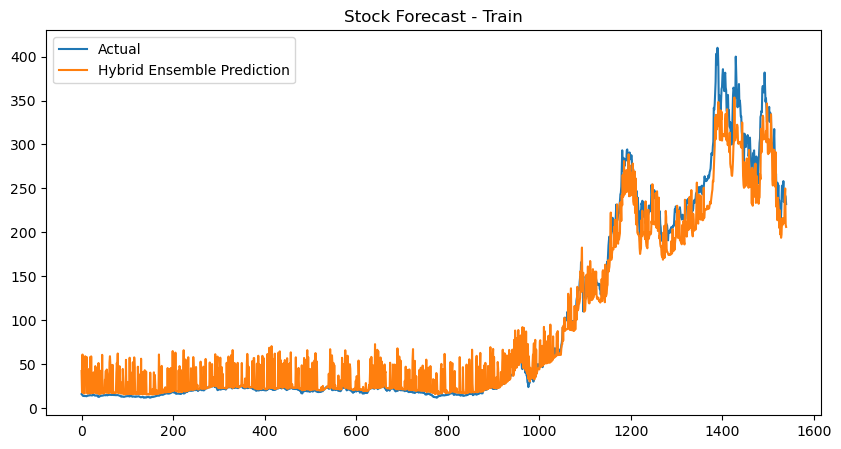

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(y_train, label="Actual")
plt.plot(final_train_preds, label="Hybrid Ensemble Prediction")
plt.title(f"{selected_dataset.title()} Forecast - Train")
plt.legend()
plt.show()

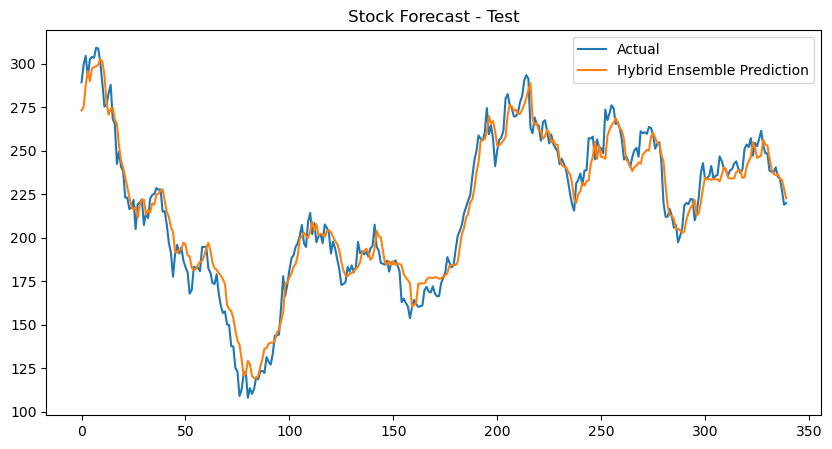

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(y_test, label="Actual")
plt.plot(final_test_preds, label="Hybrid Ensemble Prediction")
plt.title(f"{selected_dataset.title()} Forecast - Test")
plt.legend()
plt.show()

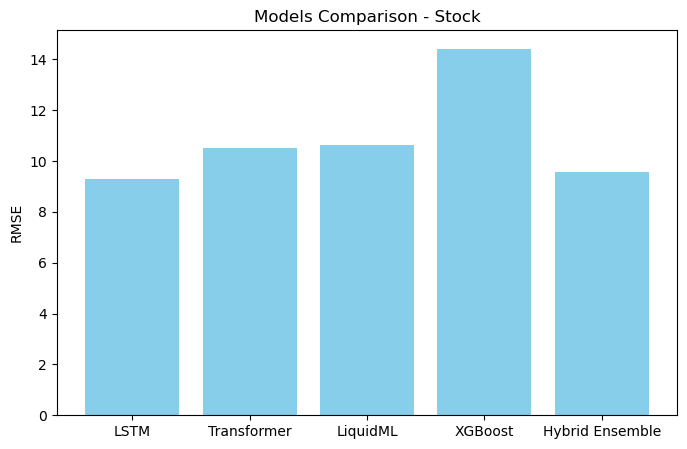

In [15]:
model_rmses.append(final_rmse_test)
labels = selected_models + ['Hybrid Ensemble']

plt.figure(figsize=(8, 5))
plt.bar(labels, model_rmses, color='skyblue')
plt.title(f"Models Comparison - {selected_dataset.title()}")
plt.ylabel("RMSE")
plt.show()